In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv('household_power_consumption.csv')

## 1. Exploratory Data Analysis (EDA)

In [4]:
# Display basic info
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Data Shape: (1048575, 9)

Data Types:
 Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Missing Values:
 Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           4069
dtype: int64


In [15]:
df.columns = df.columns.str.lower()

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [16]:
df["global_active_power"] = df["global_active_power"].replace("?", np.nan).astype(float)
df["global_reactive_power"] = df["global_reactive_power"].replace("?", np.nan).astype(float)
df["voltage"] = df["voltage"].replace("?", np.nan).astype(float)
df["global_intensity"] = df["global_intensity"].replace("?", np.nan).astype(float)
df["sub_metering_1"] = df["sub_metering_1"].replace("?", np.nan).astype(float)
df["sub_metering_2"] = df["sub_metering_2"].replace("?", np.nan).astype(float)

In [5]:
# Convert Date and Time to datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(['Date', 'Time'], axis=1)

In [ ]:
# Set DateTime as index
df.set_index('DateTime', inplace=True)

In [ ]:
c


Summary Statistics:
        global_active_power  global_reactive_power       voltage  \
count         1.044506e+06           1.044506e+06  1.044506e+06   
mean          1.108202e+00           1.182732e-01  2.399598e+02   
std           1.129546e+00           1.095062e-01  3.284504e+00   
min           7.600000e-02           0.000000e+00  2.234900e+02   
25%           2.880000e-01           0.000000e+00  2.379700e+02   
50%           5.500000e-01           9.800000e-02  2.402100e+02   
75%           1.544000e+00           1.860000e-01  2.421400e+02   
max           1.067000e+01           1.390000e+00  2.521400e+02   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      1.044506e+06    1.044506e+06    1.044506e+06    1.044506e+06  
mean       4.718123e+00    1.177451e+00    1.475177e+00    5.933837e+00  
std        4.763588e+00    6.321183e+00    6.352703e+00    8.210398e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25% 

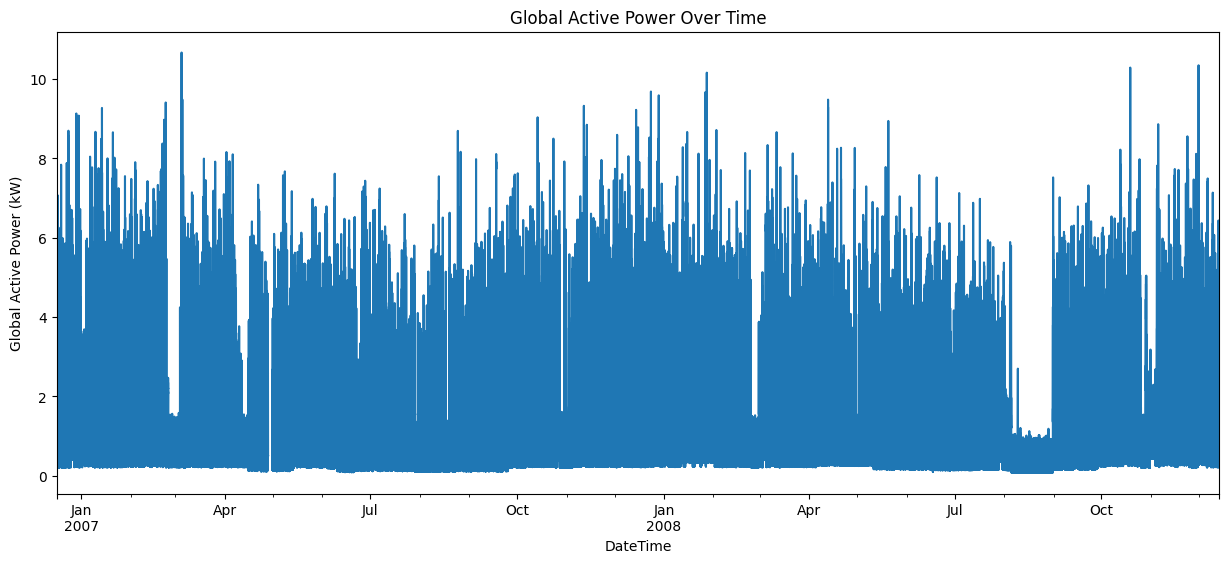

In [20]:
# Plot time series of Global_active_power
plt.figure(figsize=(15, 6))
df['global_active_power'].plot(title='Global Active Power Over Time')
plt.ylabel('Global Active Power (kW)')
plt.show()

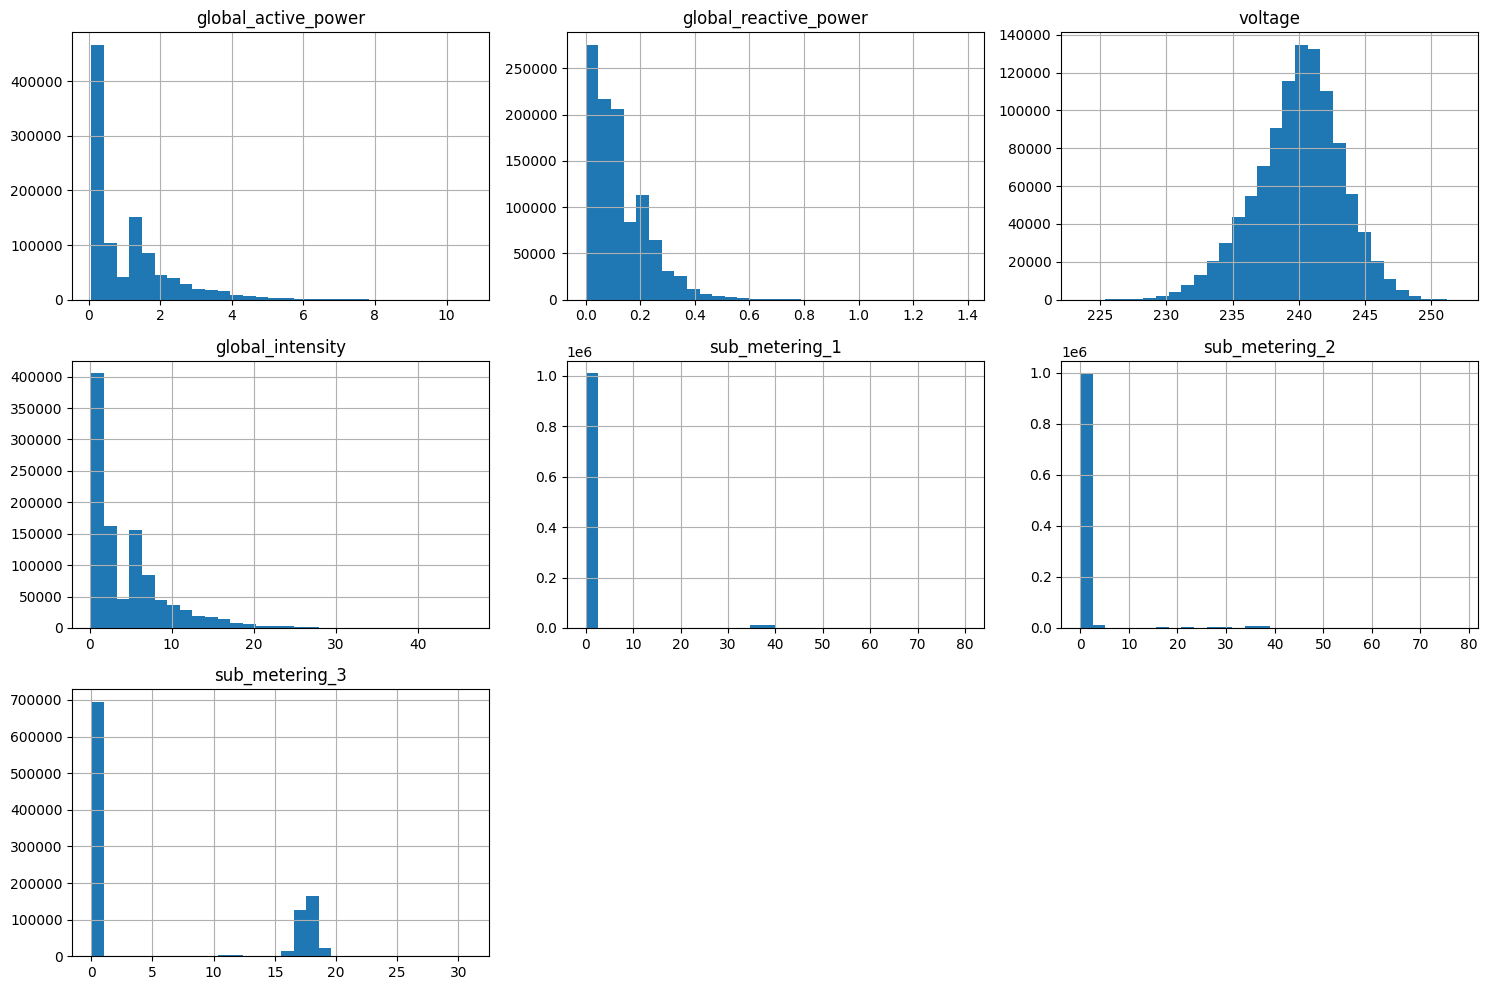

In [21]:
# Plot distribution of variables
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

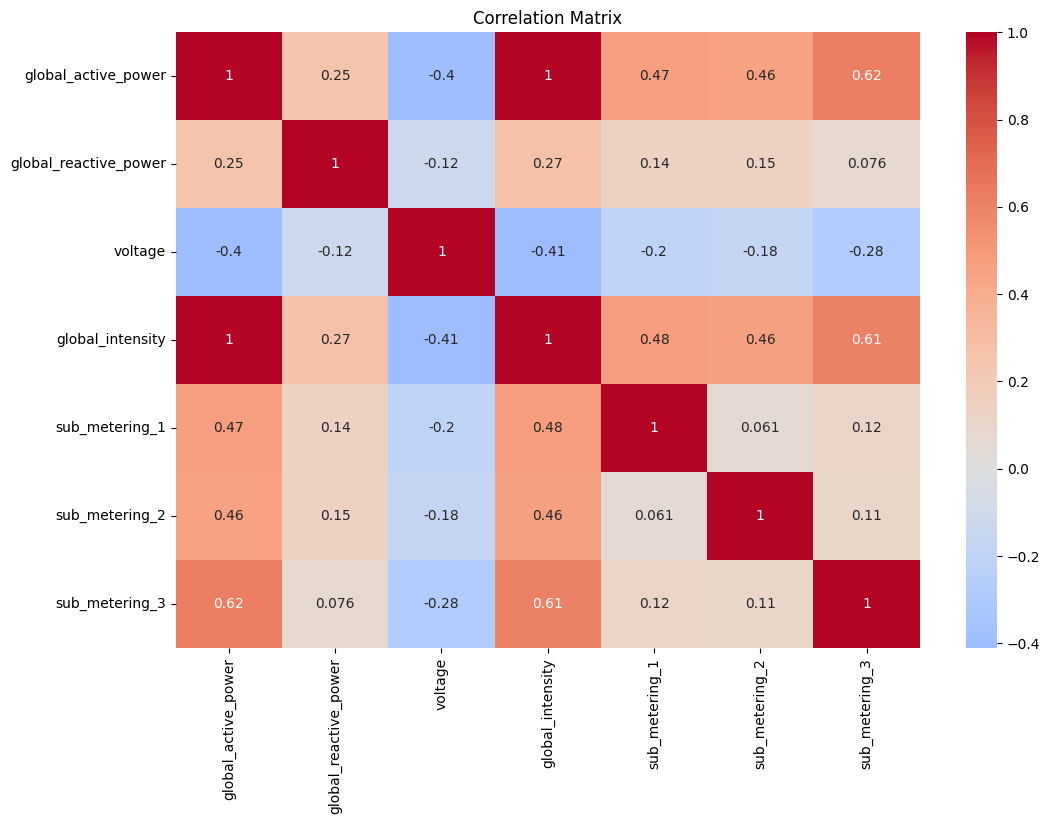

In [22]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


<Figure size 1500x600 with 0 Axes>

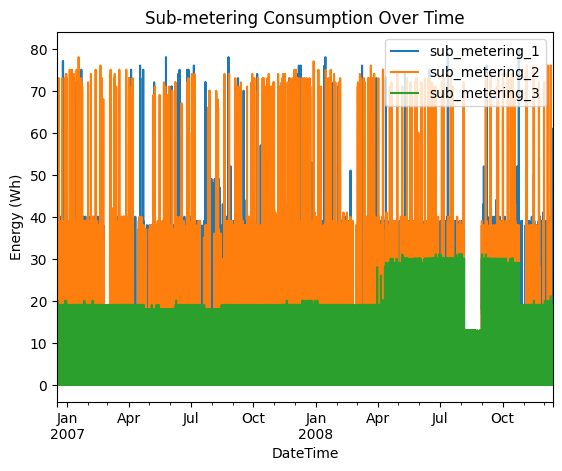

In [25]:
# Plot sub-metering consumption
plt.figure(figsize=(15, 6))
df[['sub_metering_1', 'sub_metering_2', 'sub_metering_3']].plot(title='Sub-metering Consumption Over Time')
plt.ylabel('Energy (Wh)')
plt.show()

## 2. Feature Engineering

In [26]:
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['DayOfYear'] = df.index.dayofyear

In [28]:
# Create lag features for time series
df['global_active_power_lag1'] = df['global_active_power'].shift(1)
df['global_active_power_lag2'] = df['global_active_power'].shift(2)
df['global_active_power_lag3'] = df['global_active_power'].shift(3)

In [30]:
# Create rolling statistics
df['global_active_power_rolling_mean_24h'] = df['global_active_power'].rolling(window=24).mean()
df['global_active_power_rolling_std_24h'] = df['global_active_power'].rolling(window=24).std()

In [31]:
# Drop rows with NA values created by lag features
df = df.dropna()

In [33]:
# Create target variable (next hour's Global_active_power)
df['target'] = df['global_active_power'].shift(-1)
df = df.dropna()

## 3. Data Preprocessing for Machine Learning

In [35]:
# Split into features and target
X = df.drop('target', axis=1)
y = df['target']

In [36]:
# Split into train and test sets (chronological split)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [37]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Machine Learning Prediction (Random Forest)

In [38]:
# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [39]:
# Evaluate
y_pred = rf.predict(X_test_scaled)
print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Random Forest Performance:
MAE: 0.08392771867289496
RMSE: 0.2104810828186438


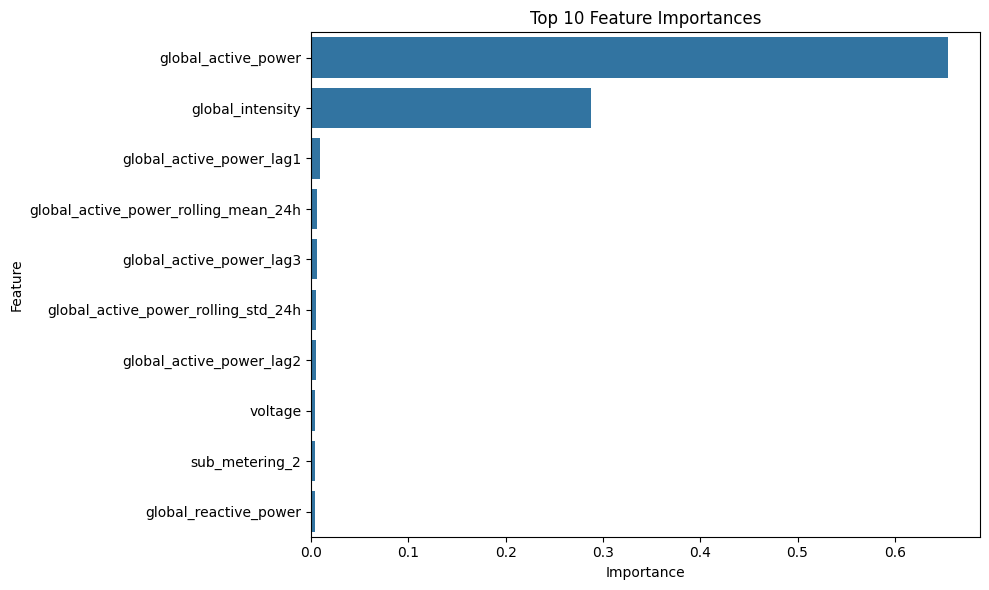

In [40]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


## 5. LSTM Time Series Prediction

In [41]:
# Prepare data for LSTM
def create_dataset(data, look_back=24):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), :])
        y.append(data[i + look_back, 0])  # Predicting Global_active_power
    return np.array(X), np.array(y)


In [44]:
df

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,Hour,DayOfWeek,Month,DayOfYear,global_active_power_lag1,global_active_power_lag2,global_active_power_lag3,global_active_power_rolling_mean_24h,global_active_power_rolling_std_24h,target
DateTime,,,,,,,,,,,,,,,,,
2006-12-16 17:47:00,5.174,0.000,234.19,22.0,0.0,0.0,17.0,17,5,12,350,7.026,7.706,5.894,4.564167,1.212742,4.474
2006-12-16 17:48:00,4.474,0.000,234.96,19.4,0.0,0.0,17.0,17,5,12,350,5.174,7.026,7.706,4.574917,1.210663,3.248
2006-12-16 17:49:00,3.248,0.000,236.66,13.6,0.0,0.0,17.0,17,5,12,350,4.474,5.174,7.026,4.486917,1.227753,3.236
2006-12-16 17:50:00,3.236,0.000,235.84,13.6,0.0,0.0,17.0,17,5,12,350,3.248,4.474,5.174,4.397833,1.238111,3.228
2006-12-16 17:51:00,3.228,0.000,235.60,13.6,0.0,0.0,17.0,17,5,12,350,3.236,3.248,4.474,4.307833,1.241507,3.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13 21:33:00,0.422,0.072,240.54,1.8,0.0,0.0,0.0,21,5,12,348,0.420,0.418,0.418,0.350333,0.043338,0.426
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,21,5,12,348,0.422,0.420,0.418,0.354583,0.045586,0.424
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,21,5,12,348,0.426,0.422,0.420,0.358750,0.047210,0.422


In [45]:
# Use only Global_active_power and important features for LSTM
lstm_features = ['global_active_power', 'global_active_power_lag1', 
                'global_active_power_lag2', 'global_active_power_lag3',
                'global_active_power_rolling_mean_24h', 'Hour', 'DayOfWeek']
X_lstm = df[lstm_features]

In [46]:
# Scale data
scaler_lstm = MinMaxScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm)

In [47]:
# Split into train and test
train_size = int(len(X_lstm_scaled) * 0.8)
train, test = X_lstm_scaled[:train_size], X_lstm_scaled[train_size:]

In [48]:
# Create sequences
look_back = 24  # Using 24 hours as lookback window
X_train_lstm, y_train_lstm = create_dataset(train, look_back)
X_test_lstm, y_test_lstm = create_dataset(test, look_back)

In [49]:
# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], look_back, X_train_lstm.shape[2])
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], look_back, X_test_lstm.shape[2])

In [50]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 468s 18ms/step - loss: 0.0013 - val_loss: 5.3044e-04
Epoch 2/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 477s 18ms/step - loss: 8.6134e-04 - val_loss: 4.9738e-04
Epoch 3/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 451s 17ms/step - loss: 8.3918e-04 - val_loss: 4.8184e-04
Epoch 4/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 458s 18ms/step - loss: 8.1653e-04 - val_loss: 4.8090e-04
Epoch 5/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 500s 19ms/step - loss: 8.0195e-04 - val_loss: 4.7063e-04
Epoch 6/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 514s 20ms/step - loss: 7.8677e-04 - val_loss: 4.8643e-04
Epoch 7/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 523s 20ms/step - loss: 7.7548e-04 - val_loss: 4.8020e-04
Epoch 8/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 567s 22ms/step - loss: 7.6802e-04 - val_loss: 4.5880e-04
Epoch 9/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 570s 22ms/step - loss: 7.5024e-04 - val_loss: 4.4881e-04
Epoch 10/50
26090/26090 ━━━━━━━━━━━━━━━━━━━━ 683s 24ms/step - loss: 7.4393e-04 - val_loss: 4.50

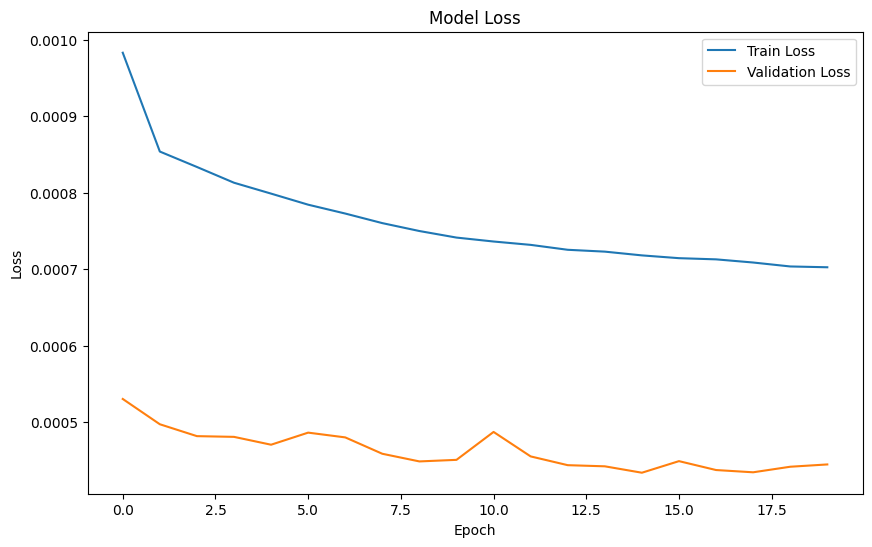

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [53]:
# Evaluate LSTM
y_pred_lstm = model.predict(X_test_lstm)

6522/6522 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step


In [55]:
# Inverse scaling for evaluation
y_test_inv = y_test_lstm * (X_lstm['global_active_power'].max() - X_lstm['global_active_power'].min()) + X_lstm['global_active_power'].min()
y_pred_inv = y_pred_lstm * (X_lstm['global_active_power'].max() - X_lstm['global_active_power'].min()) + X_lstm['global_active_power'].min()

print("\nLSTM Performance:")
print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))


LSTM Performance:
MAE: 0.07894988920152277
RMSE: 0.22071009612749723


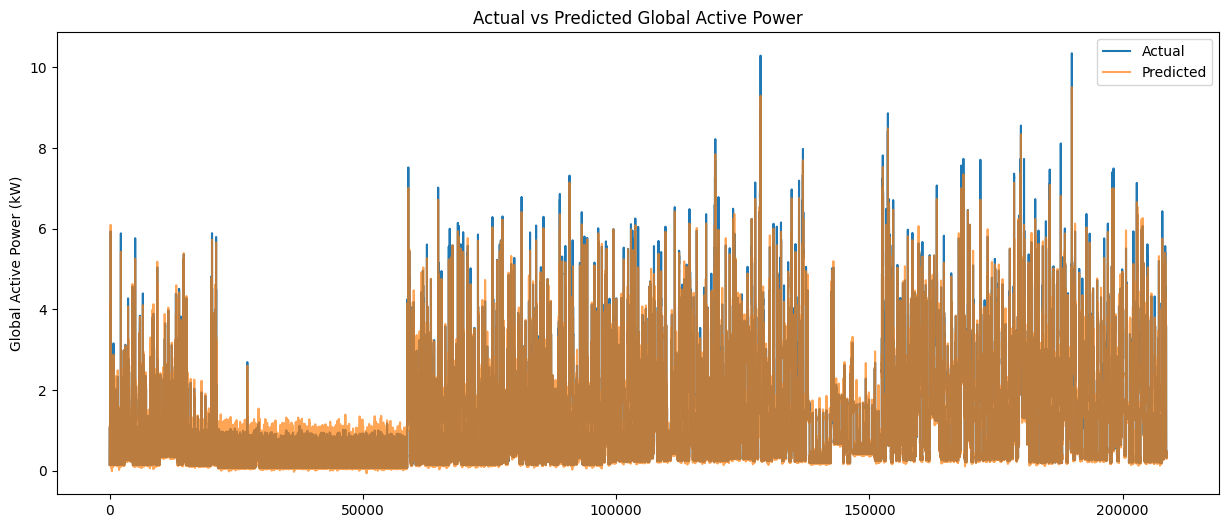

In [56]:
# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Global Active Power')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [4]:
new_data = pd.DataFrame({
    'global_active_power': [2.9],
    'global_reactive_power': [0.12],
    'voltage': [240.1],
    'global_intensity': [10.5],
    'sub_metering_1': [0],
    'sub_metering_2': [1],
    'sub_metering_3': [17],
    'Hour': [15],
    'DayOfWeek': [2],
    'Month': [12],
    'DayOfYear': [351],
    'global_active_power_lag1': [2.4],
    'global_active_power_lag2': [2.3],
    'global_active_power_lag3': [2.2],
    'global_active_power_rolling_mean_24h': [2.35],
    'global_active_power_rolling_std_24h': [0.15]
})

# 2. Scale the features using the same scaler from training
new_data_scaled = scaler.transform(new_data)

# 3. Make prediction
rf_prediction = rf.predict(new_data_scaled)
print(f"Random Forest Prediction for next hour's Global Active Power: {rf_prediction[0]:.2f} kW")

NameError: name 'pd' is not defined

In [87]:
sequence_length = 24
last_sequence = X_lstm_scaled[-sequence_length:]  # Takes the last 24 hours from training data

# If you have truly new data, you would need to:
# 1. Preprocess it the same way as training data
# 2. Scale it using the same scaler_lstm
# 3. Create sequences of 24 hours

# 2. Reshape for LSTM [1 sample, 24 timesteps, n_features]
last_sequence = last_sequence.reshape(1, sequence_length, len(lstm_features))

# 3. Make prediction
lstm_prediction = model.predict(last_sequence)

# 4. Inverse transform the prediction to original scale
lstm_prediction_original = lstm_prediction * (X_lstm['global_active_power'].max() - X_lstm['global_active_power'].min()) + X_lstm['global_active_power'].min()
print(f"LSTM Prediction for next hour's Global Active Power: {lstm_prediction_original[0][0]:.2f} kW")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM Prediction for next hour's Global Active Power: 0.41 kW


In [61]:
import joblib
from tensorflow.keras.models import load_model

# Save models and scalers
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(scaler_lstm, 'scaler_lstm.pkl')
joblib.dump(lstm_features, 'lstm_features.pkl')  # Save feature list for LSTM
model.save('lstm_model.h5')



In [1]:
import joblib
from tensorflow.keras.models import load_model

In [2]:
# Later, load them:
rf_loaded = joblib.load('random_forest_model.pkl')
scaler_loaded = joblib.load('scaler.pkl')
scaler_lstm_loaded = joblib.load('scaler_lstm.pkl')
lstm_features_loaded = joblib.load('lstm_features.pkl')
lstm_model_loaded = load_model('lstm_model.h5')